In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")
import os

import numpy as np
import CNN_Module as cnn_module
import skimage
import numpy as np
import pickle
import gc
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
from keras import backend
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from keras.optimizers import SGD,Adadelta
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import random
import glob
import CNN_Module as cnn_module
import models
import glue_code
from keras.utils.layer_utils import print_summary
from keras.models import load_model
from keras.models import save_model
from keras.preprocessing.image import load_img, img_to_array

from plotting import visualise_img_in_layer
from plotting import plti

Using TensorFlow backend.


In [ ]:
result_acc = []
result_val_acc = []

video_path = '/cropped_video100_140'
sample_gap = 10
epochs=20
stepsperepoch=100

#prep cells for feeding into CNN
control_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/susceptible/'))
sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/resistant/'))

#label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
control_cells_label = cnn_module.create_label_dict(control_cells,0)
sus_cells_label  = cnn_module.create_label_dict(sus_cells,1)
train_ctrl, test_ctrl = cnn_module.split_train_test(control_cells_label,0.9)
train_sus, test_sus = cnn_module.split_train_test(sus_cells_label,0.9)
train_labels = train_ctrl+train_sus
test_labels = test_ctrl+test_sus


im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images(train_labels,test_labels,video_path,sample_gap)
random.shuffle(im_paths_train)
random.shuffle(im_paths_test)

model = models.get_luke_model_140((140,100,1))

augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train, params_test = cnn_module.get_params_train_test(140,100,augment_valid,augment_valid) #no flipping

training_generator = DataGenerator.DataGenerator(im_paths_train, im_labels_train, **params_train)
prediction_generator = DataGenerator.DataGenerator(im_paths_test, im_labels_test, **params_test)

validate_steps = len(im_paths_test)//32

fully_train_model = cnn_module.fit_model(model,training_generator,prediction_generator,epochs,stepsperepoch,validate_steps,params_train,params_test)
#pickle.dump(fully_train_model, open("/home/ubuntu/data/code/Visualisation/2d100_140nn.p", "wb"))


In [4]:
#save_model(fully_train_model,"/home/ubuntu/data/code/Visualisation/2d100_140nn")
model = load_model("/home/ubuntu/data/code/visualisation/2d_cipro1")

#model = fully_train_model
print(model.summary())













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 140, 100, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 140, 100, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 70, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 50, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 70, 50, 32)        128       
_________________________________________________

conv2d_1 (3, 3, 1, 32)
conv2d_2 (3, 3, 32, 32)
conv2d_3 (3, 3, 32, 32)
conv2d_4 (3, 3, 32, 64)


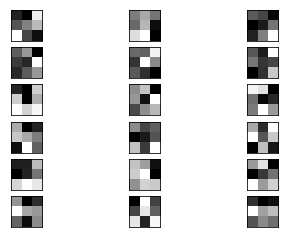

In [8]:
from matplotlib import pyplot

# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

## we will only be looking at filters from the first layer - no clever enought to interpret deeper :(

n_filters, ix = 6, 1
# n_filters is number of rows of filters shown, ix iterates from 1

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]

    # plot each channel separately
    for j in range(3):
        #specify subplot and turn off axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

conv2d_1 (3, 3, 1, 32)
conv2d_2 (3, 3, 32, 32)
conv2d_3 (3, 3, 32, 32)
conv2d_4 (3, 3, 32, 64)


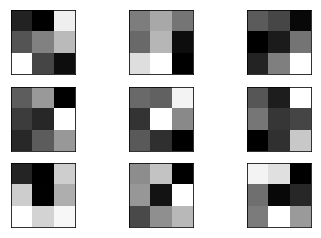

In [6]:
from matplotlib import pyplot
# load the model

for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)
    
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 3, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()